In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/customer-shopping-trends-dataset          Customer Shopping Trends Dataset                 146KB  2023-10-05 06:45:37          21786        455  1.0              
samyakb/student-stress-factors                              Student stress factors                            887B  2023-11-02 12:42:11           2390         56  0.9411765        
nelgiriyewithana/billionaires-statistics-dataset            Billionaires Statistics Dataset (2023)           139KB  2023-09-29 13:39:28          11976        288  1.0              
joebeachcapital/30000-spotify-songs

In [ ]:
! kaggle datasets download -d sarjit07/hand-gesture-recog-dataset

100% 42.9M/42.9M [00:03<00:00, 22.5MB/s]
100% 42.9M/42.9M [00:03<00:00, 14.2MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('hand-gesture-recog-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np # We'll be storing our data as numpy arrays
import os # For handling directories
from PIL import Image # For handling the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Plotting

In [ ]:
# Loading the Dataset

DATASET_PATH = '/content/data'

dataset_path = os.path.join(DATASET_PATH, '*')
import glob
dataset_path = glob.glob(dataset_path)
dataset_path

['/content/data/thumbsup',
 '/content/data/ok',
 '/content/data/blank',
 '/content/data/thumbsdown',
 '/content/data/five',
 '/content/data/fist']

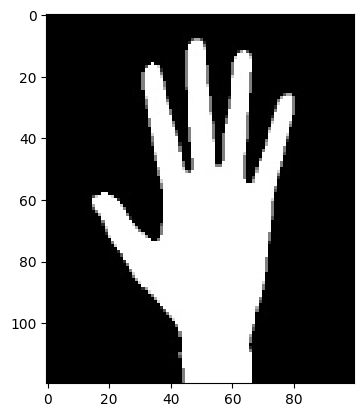

In [ ]:
import cv2
image = cv2.imread('/content/data/five/hand1(1015).jpg')
image = cv2.resize(image,(100, 120))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
loaded_images = []

list_of_gestures = ['blank', 'fist', 'five']

# to convert the image to grayscale for CNN model training
for path in range(0, 3):
    dataset_path = "/content/data/" + str(list_of_gestures[path])
    gesture_path = os.path.join(dataset_path, '*')
    import glob
    gest_path = glob.glob(gesture_path)
    k = 0
    for i in range(0, len(gest_path)):
        if k < 1600:
            image = cv2.imread(gest_path[i])
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray_image = cv2.resize(gray_image,(100, 120))
            loaded_images.append(gray_image)
        k=k+1
print(len(loaded_images))

y_data = []

for i in range(3):
  for j in range(1600):
    y_data.append(i)

print(len(y_data))

4800
4800


In [ ]:
x = np.asarray(loaded_images)
x = x.reshape((4800, 1, 120, 100))
y = np.asarray(y_data)
print(x.shape)
print(y.shape)

(4800, 1, 120, 100)
(4800,)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
x_data_tensor = torch.Tensor(x)
y_data_tensor = torch.Tensor(y).to(torch.int64)

In [ ]:
from sklearn.model_selection import train_test_split
# to split dataset into training and testing sets
x_train,x_test,y_train,y_test = train_test_split(x_data_tensor,y_data_tensor,test_size = 0.3)

In [ ]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = 64)
test_loader = DataLoader(test_dataset, batch_size = 64)

train_loader

In [ ]:
class CNNModel(nn.Module):
    def __init__(self): # class constructor function

        super(CNNModel, self).__init__() # initialize an instance of the parent class

        # first convolutional and maxpool layer
        # input 1x120x100, output 16x116x96
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size=(5, 5))
        # input 16x116x96, output 16x58x48
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # second convolutional and maxpool layer
        # input 16x58x48, output 32x54x44
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5))
        # input 32x54x44, output 32x27x22
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # linear layer
        self.fc1 = nn.Linear(in_features=19008, out_features=120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,3)


    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool1(x)

        # Layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool2(x)

        # Output Fully Connected Layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = x

        # return the output predictions
        return output

model = CNNModel()

In [ ]:
# define training hyperparameters
lr = 1e-2 # learning rate
num_epochs = 50 # number of epochs

# set the device we will be using to train the model (to enable hardware acceleration)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss() # loss function
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9) # optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

model.to(device)

for e in range(0, num_epochs):
	# set the model in training mode
	model.train()

  # initialize the total training and validation loss
	totalTrainLoss = 0

  # initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0

  # loop over the training set
	for i, (x, y) in enumerate(train_loader):

    # send the input to the device
		(x, y) = (x.to(device), y.to(device))

		pred = model(x) # forward pass
		loss = criterion(pred, y) # compute training loss

		optimizer.zero_grad() # zero out the gradients
		loss.backward() # perform backpropagation step
		optimizer.step() # update weights

		# calculate the number of correct predictions
		totalTrainLoss += loss # add the loss to the cumulative training loss
	print("Epoch", e, "Training Loss:", totalTrainLoss.item())

Epoch 0 Training Loss: 529.3844604492188
Epoch 1 Training Loss: 10.585504531860352
Epoch 2 Training Loss: 3.550658941268921
Epoch 3 Training Loss: 1.1858636140823364
Epoch 4 Training Loss: 0.46529069542884827
Epoch 5 Training Loss: 0.8197588920593262
Epoch 6 Training Loss: 0.34876748919487
Epoch 7 Training Loss: 0.12606610357761383
Epoch 8 Training Loss: 0.07592780888080597
Epoch 9 Training Loss: 0.008394180797040462
Epoch 10 Training Loss: 0.0021778112277388573
Epoch 11 Training Loss: 0.0015005990862846375
Epoch 12 Training Loss: 0.0011776882456615567
Epoch 13 Training Loss: 0.0009585160296410322
Epoch 14 Training Loss: 0.0007998263463377953
Epoch 15 Training Loss: 0.0006805239245295525
Epoch 16 Training Loss: 0.0005877163494005799
Epoch 17 Training Loss: 0.0005139040295034647
Epoch 18 Training Loss: 0.0004540436202660203
Epoch 19 Training Loss: 0.0004045404784847051
Epoch 20 Training Loss: 0.00036308704875409603
Epoch 21 Training Loss: 0.0003278452786616981
Epoch 22 Training Loss: 0.

In [ ]:
import numpy as np
model.eval() # enable model evaluation mode
correct_sum_train = 0
total_train = 0
correct_sum_test = 0
total_test = 0
with torch.no_grad():
  for i, (data, target) in enumerate(train_loader):

    # send the input to the device
    (data, target) = (data.to(device), target.to(device))
    output = model(data)

    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # _, target = torch.max(target, 1)

    # compare predictions to true label
    correct_tensor = pred.eq(target)
    correct = np.squeeze(correct_tensor)

    # calculate train accuracy
    correct_sum_train += correct.sum().item()
    total_train += target.size(0)


correct_count = np.sum(correct_sum_train)
total_count = np.sum(total_train)
train_accuracy =  round(100.0 * (correct_count / total_count), 6)
formatted_accuracy = "{:.6f}".format(train_accuracy)

print(f"Train Accuracy (Overall): {formatted_accuracy} ({correct_count}/{total_count})")

with torch.no_grad():
  for i, (data, target) in enumerate(test_loader):

    # send the input to the device
    (data, target) = (data.to(device), target.to(device))
    output = model(data)

    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # _, target = torch.max(target, 1)

    # compare predictions to true label
    correct_tensor = pred.eq(target)
    correct = np.squeeze(correct_tensor)

    # calculate test accuracy
    correct_sum_test += correct.sum().item()
    total_test += target.size(0)


correct_count = np.sum(correct_sum_test)
total_count = np.sum(total_test)
test_accuracy =  round(100.0 * (correct_count / total_count), 6)
formatted_accuracy = "{:.6f}".format(test_accuracy)

print(f"Test Accuracy (Overall): {formatted_accuracy} ({correct_count}/{total_count})")

Train Accuracy (Overall): 100.000000 (3360/3360)
Test Accuracy (Overall): 98.958333 (1425/1440)


In [ ]:
# to save the trained model as .pt file
model_save_name = 'handclassifier6.pt'
# path = f"/content/drive/MyDrive/{model_save_name}"
path = f"/content/{model_save_name}"
torch.save(model.state_dict(), path)